In [176]:
import os, re, time, sys
import pandas as pd
import numpy as np
from  geopy.geocoders import Nominatim
from dateutil.parser import parse
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def text2int(textnum, numwords={}):
    if not numwords:
      units = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen",
      ]

      tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

      scales = ["hundred", "thousand", "million", "billion", "trillion"]

      numwords["and"] = (1, 0)
      for idx, word in enumerate(units):    numwords[word] = (1, idx)
      for idx, word in enumerate(tens):     numwords[word] = (1, idx * 10)
      for idx, word in enumerate(scales):   numwords[word] = (10 ** (idx * 3 or 2), 0)

    current = result = 0
    for word in textnum.split():
        if word not in numwords:
            break
#           raise Exception("Illegal word: " + word)
            

        scale, increment = numwords[word]
        current = current * scale + increment
        if scale > 100:
            result += current
            current = 0

    return result + current

In [4]:
def locFromText(text):
    tofilter = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen","strike","strikes","near","destroyed","the","engaged"
      ]
    t = re.search(r'Near (.*?)(?:[,;]|(?!.*\b(?:one|two|three|four|five|six|seven|eight|nine|ten)\b)){1,3}', text)
    if t:
        red=' '.join(t.group(1).split()[:5])
        red = red.replace('and','|')
        red = red.replace('-',' ')
        red = red.replace('ar','al')
        red = red.lower()
        if len(red) < 2:
            return None
        else:
            return " ".join([w for w in red.split() if not w in tofilter])
    else:
        return None

## Import the previously parsed data

In [125]:
df = pd.read_feather('allreports.feather')
df.shape

(9723, 4)

In [126]:
df["loc"] = df.apply(lambda x: locFromText(x.text), axis=1)
# print(df["loc"].unique())

In [127]:
# Get Number of Strikes
df["strikes"] = df.apply(lambda x: x["text"].split(' strike',1)[0].split(', ')[-1],axis=1)
df["strikes"] = df.apply(lambda x: x.strikes if x.strikes.isnumeric() else text2int(x.strikes), axis=1)

## Location Lookup Table

In [21]:
locdf=pd.DataFrame(df["loc"].unique(),columns=["city"])

In [27]:
locdf.fillna(value=pd.np.nan, inplace=True)
locdf.dropna(inplace=True)
locdf.head(10)

,city
0,al shadaddi
1,ar raqqah
2,tabqah
3,al qaim
4,haditha
5,mosul
6,tal afal
7,dayr az zawr
9,huwijah
10,rawah


In [48]:
def g(t):
    l=geolocator.geocode(t,timeout = 10)
    if l:
        return [l.longitude, l.latitude]
    else:
        pd.np.nan

geolocator = Nominatim()
geolocator.country_bias = "SY"
locdf["location"] = locdf.apply(lambda x: g(x["city"]), axis=1 )
locdf

/Users/andrewlb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


,city,location
0,al shadaddi,None
1,ar raqqah,"[39.0089212, 35.949678]"
2,tabqah,"[38.5414697, 35.8323648]"
3,al qaim,None
4,haditha,None
...,...,...
159,shadaddi,None
160,dayr az,"[40.1499999, 35.3333335]"
161,tal abayad,None
162,dayr palymyra,None


In [47]:
geolocator.geocode("raqqah, SY")≈Ω

Location(الرقة, Sūriyya سوريا, (35.949678, 39.0089212, 0.0))

In [49]:
locdf.head(10)

,city,location
0,al shadaddi,None
1,ar raqqah,"[39.0089212, 35.949678]"
2,tabqah,"[38.5414697, 35.8323648]"
3,al qaim,None
4,haditha,None
5,mosul,None
6,tal afal,None
7,dayr az zawr,"[40.1499999, 35.3333335]"
9,huwijah,None
10,rawah,None


In [57]:
df.head()

,index,report,text,filename,loc,strikes
0,1,20170406-01," Near Al Shadaddi, one strike engaged an ISIS...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,al shadaddi,1
1,3,20170406-01," Near Ar Raqqah, two strikes destroyed an ISI...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,ar raqqah,2
2,5,20170406-01," Near Tabqah, 13 strikes engaged nine ISIS ta...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,tabqah,13
3,7,20170406-01," Near Al Qaim, one strike destroyed two anti-...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,al qaim,1
4,9,20170406-01," Near Haditha, one strike engaged an ISIS tac...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,haditha,1


In [85]:
df["coords"] = df.apply(lambda x: locdf.loc[locdf['city'] == x["loc"]]["location"], axis=1)

In [86]:
df.head(30)

,index,report,text,filename,loc,strikes,coords
0,1,20170406-01," Near Al Shadaddi, one strike engaged an ISIS...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,al shadaddi,1,NaN
1,3,20170406-01," Near Ar Raqqah, two strikes destroyed an ISI...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,ar raqqah,2,NaN
2,5,20170406-01," Near Tabqah, 13 strikes engaged nine ISIS ta...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,tabqah,13,NaN
3,7,20170406-01," Near Al Qaim, one strike destroyed two anti-...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,al qaim,1,NaN
4,9,20170406-01," Near Haditha, one strike engaged an ISIS tac...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,haditha,1,NaN
5,11,20170406-01," Near Mosul, six strikes engaged four ISIS ta...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,mosul,6,NaN
6,13,20170406-01," Near Tal Afar, one strike engaged an ISIS ta...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,tal afal,1,NaN
7,1,20170927-01," Near Al Shadaddi, one strike engaged an ISIS...",20170927%20Strike%20Release.pdf?ver=2017-09-27...,al shadaddi,1,NaN
8,2,20170927-01," Near Dayr Az Zawr, one strike engaged an ISI...",20170927%20Strike%20Release.pdf?ver=2017-09-27...,dayr az zawr,1,NaN
9,4,20170927-01," Near Raqqah, 35 strikes engaged 15 ISIS tact...",20170927%20Strike%20Release.pdf?ver=2017-09-27...,None,35,NaN


## Getting Datetime set up

In [122]:
# Fix to one of the report IDs
# On second thought, this is a bad idea, because I want to assoc with report ID, even if they are incorrect
# df.at[142,"report"] = "20160528-1"
# df.at[143,"report"] = "20160528-1"
# df.at[144,"report"] = "20160528-1"
# df.at[145,"report"] = "20160528-1"
# df.at[146,"report"] = "20160528-1"
# df.at[147,"report"] = "20160528-1"
# df.at[148,"report"] = "20160528-1"
# df.at[149,"report"] = "20160528-1"
# df.at[150,"report"] = "20160528-1"
# df.at[151,"report"] = "20160528-1"
# df.at[152,"report"] = "20160528-1"
# df.at[153,"report"] = "20160528-1"
# df.at[154,"report"] = "20160528-1"
# df.at[155,"report"] = "20160528-1"
# df.at[156,"report"] = "20160528-1"

In [128]:
# Convert the initial dates as referenced in reports
df["report_date"] = df.apply(lambda x : pd.to_datetime( x["report"].split("-")[0], errors="coerce",yearfirst=True),axis=1)

In [141]:
nulldates = pd.isnull(df["report_date"]).nonzero()

/Users/andrewlb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  """Entry point for launching an IPython kernel.


In [168]:
date_pattern = re.compile("([0-9]{4}\-[0-9]{2}\-[0-9]{2})")

def extract_date(filename):
    matches = re.search("([0-9]{2}\-[0-9]{2}\-[0-9]{4})", filename)
    if matches:
        return parse(matches.group(0))
    else:
        return None
    
print(df.loc[539,"report"])
print(df.loc[539,"filename"].replace("%20"," "))
print(extract_date(df.loc[539,"filename"].replace("%20"," ")))
#parse( ,fuzzy_with_tokens=True)

2015011
11 Jan Strike Release.pdf?ver=2017-01-13-131050-560.pdf
None


In [ ]:
df["report_date"] = df.apply(lambda x : x if !pd.isnull(x["report_date"])

In [180]:
unmatched = pd.DataFrame(df.loc[nulldates]["filename"].unique(),columns=["filename"])
unmatched["date"] = np.nan

In [256]:
unmatched.at[0,"date"] = "20160528"
unmatched.at[1,"date"] = "20150125"
unmatched.at[2,"date"] = "20150111"
unmatched.at[3,"date"] = "20150426"
unmatched.at[4,"date"] = "20151013"
unmatched.at[5,"date"] = "20151018"
unmatched.at[6,"date"] = "20160526"
unmatched.at[7,"date"] = "20151010"
unmatched.at[8,"date"] = "20151017"
unmatched.at[9,"date"] = "20150107"
unmatched.at[10,"date"] = "20150419"
unmatched.at[11,"date"] = "20150103"
unmatched.at[12,"date"] = "20150105"
unmatched.at[13,"date"] = "20150201"
unmatched.at[14,"date"] = "20160531"
unmatched.at[15,"date"] = "20160525"
unmatched.at[16,"date"] = "20150123"
unmatched.at[17,"date"] = "20160521"
unmatched.at[18,"date"] = "20150106"
unmatched.at[19,"date"] = "20181128"
unmatched.at[20,"date"] = "20170129"
unmatched.at[21,"date"] = "20150110"
unmatched.at[22,"date"] = "20150104"
unmatched.at[23,"date"] = "20150126"
unmatched.at[24,"date"] = "20151019"
unmatched.at[25,"date"] = "20150415"
unmatched.at[26,"date"] = "20150426"
unmatched.at[27,"date"] = "20151015"
unmatched.at[28,"date"] = "20151012"
unmatched.at[29,"date"] = "20150213"
unmatched.at[30,"date"] = "20150112"
unmatched.at[31,"date"] = "20150522"
unmatched.at[32,"date"] = "20161122"
unmatched.at[33,"date"] = "20150108"
unmatched.at[34,"date"] = "20150115"
unmatched.at[35,"date"] = "20160522"
unmatched.at[36,"date"] = "20150118"
unmatched.at[37,"date"] = "20150101"
unmatched.at[38,"date"] = "20161121"
unmatched.at[39,"date"] = "20150114"
unmatched.at[40,"date"] = "20160520"
unmatched.at[41,"date"] = "20170121"
unmatched.at[42,"date"] = "20150431"
unmatched.at[43,"date"] = "20160524"
unmatched.at[44,"date"] = "20150116"
unmatched.at[45,"date"] = "20150122"
unmatched.at[46,"date"] = "20151016"
unmatched.at[47,"date"] = "20151011"
unmatched.at[48,"date"] = "20160523"
unmatched.at[49,"date"] = "20160529"
unmatched.at[50,"date"] = "20160530"
unmatched.at[51,"date"] = "20150109"
unmatched.at[52,"date"] = "20150113"
unmatched.at[53,"date"] = "20150503"
unmatched.at[54,"date"] = "20150119"
unmatched.at[55,"date"] = "20150124"
unmatched.at[56,"date"] = "20151014"
unmatched.at[57,"date"] = "20150120"
unmatched.at[58,"date"] = "20150121"
unmatched.at[59,"date"] = "20150117"
unmatched.at[60,"date"] = "20150413"
unmatched.at[61,"date"] = "20160527"
unmatched.at[62,"date"] = "20181121"
unmatched.at[63,"date"] = "20150102"
unmatched.at[64,"date"] = "20170122"

In [270]:
unmatched['datetime'] = pd.to_datetime(unmatched['date'].astype(str).apply(lambda x:x.split(".")[0]),
                                       yearfirst=True, 
                                       format="%Y%m%d",
                                       exact=False,
                                       errors='coerce')

In [272]:
unmatched.to_feather("broken-dates.feather") #Just a quick backup...

In [279]:
df.dtypes

index                   int64
report                 object
text                   object
filename               object
loc                    object
strikes                object
report_date    datetime64[ns]
dtype: object

In [287]:
df["report_date"] = df.apply(lambda x: 
                             unmatched.loc[unmatched['filename'] == x["filename"]]["datetime"]
                             if pd.isnull(x["report_date"])
                             else x["report_date"],
                             axis=1)





In [288]:
df.loc[142]

index                                                          1
report                                                2016028-01
text            Near Ar Raqqah, one strike struck an ISIL ve...
filename       20160528%20Strike%20Release%20Final.pdf?ver=20...
loc                                                    ar raqqah
strikes                                                        1
report_date                      [2016-05-28T00:00:00.000000000]
Name: 142, dtype: object

## Merge with main DF

## Plot Initial Values

In [144]:
df['AGE'].plot.hist(title='Proportion of owner-occupied units built prior to 1940', colormap='jet')
plt.xlabel('AGE')
plt.ylabel('FREQUENCY')

KeyError: 'AGE'

In [291]:

df["strikes"] = pd.to_numeric(df["strikes"])

In [298]:
df.set_index("report_date")

,index,report,text,filename,loc,strikes
report_date,,,,,,
2017-04-06,1,20170406-01," Near Al Shadaddi, one strike engaged an ISIS...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,al shadaddi,1
2017-04-06,3,20170406-01," Near Ar Raqqah, two strikes destroyed an ISI...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,ar raqqah,2
2017-04-06,5,20170406-01," Near Tabqah, 13 strikes engaged nine ISIS ta...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,tabqah,13
2017-04-06,7,20170406-01," Near Al Qaim, one strike destroyed two anti-...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,al qaim,1
2017-04-06,9,20170406-01," Near Haditha, one strike engaged an ISIS tac...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,haditha,1
...,...,...,...,...,...,...
2015-05-24,10,20150524," Near Mosul, four airstrikes struck two ISIL ...",24%20May%20Strike%20Release.pdf?ver=2017-01-13...,mosul,0
2015-05-24,12,20150524," Near Ramadi, four airstrikes struck an ISIL ...",24%20May%20Strike%20Release.pdf?ver=2017-01-13...,ramadi,0
2015-05-24,14,20150524," Near Sinjar, one airstrike struck an ISIL ta...",24%20May%20Strike%20Release.pdf?ver=2017-01-13...,sinjal,0


In [319]:
df["report_date"].min

<bound method Series.min of 0       2017-04-06 00:00:00
1       2017-04-06 00:00:00
2       2017-04-06 00:00:00
3       2017-04-06 00:00:00
4       2017-04-06 00:00:00
               ...         
9718    2015-05-24 00:00:00
9719    2015-05-24 00:00:00
9720    2015-05-24 00:00:00
9721    2015-05-24 00:00:00
9722    2015-05-24 00:00:00
Name: report_date, Length: 9723, dtype: object>

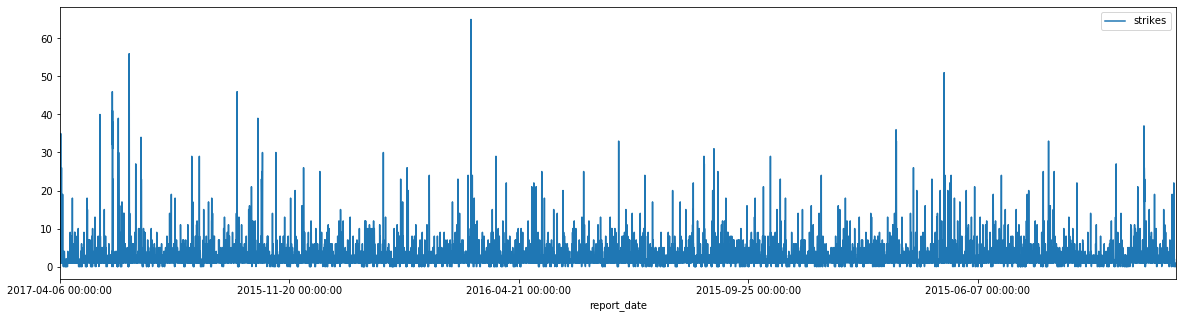

In [313]:
df.sort_index().plot(x="report_date",y="strikes",figsize=[20,5])

In [306]:
df.groupby(pd.Grouper(key='report_date', freq='M'))#.plot(x="report_date",y="strikes")

TypeError: '<' not supported between instances of 'Timestamp' and 'int'

In [320]:
df[df["filename"]=="CJTF-OIR%20Strike%20Release%20201808013-02.pdf?ver=2018-08-13-093333-010.pdf"]

,index,report,text,filename,loc,strikes,report_date
6912,1,20180813-02," Near Sharqat, one strike destroyed one Daesh...",CJTF-OIR%20Strike%20Release%20201808013-02.pdf...,shalqat,1,2018-08-13 00:00:00
6913,2,20180813-02," Near Hamrin Mountains, one strike destroyed ...",CJTF-OIR%20Strike%20Release%20201808013-02.pdf...,hamrin mountains,1,2018-08-13 00:00:00
6914,4,20180813-02," Near Abu Kamal, one strike destroyed nine Da...",CJTF-OIR%20Strike%20Release%20201808013-02.pdf...,abu kamal,1,2018-08-13 00:00:00
6915,6,20180813-02," Near Abu Kamal, two strikes destroyed 42 Dae...",CJTF-OIR%20Strike%20Release%20201808013-02.pdf...,abu kamal,2,2018-08-13 00:00:00
6916,8,20180813-02," Near Bashir, two strikes destroyed two Daesh...",CJTF-OIR%20Strike%20Release%20201808013-02.pdf...,bashir,2,2018-08-13 00:00:00
6917,10,20180813-02," Near Abu Kamal, one strike engaged one Daesh...",CJTF-OIR%20Strike%20Release%20201808013-02.pdf...,abu kamal,1,2018-08-13 00:00:00
6918,12,20180813-02," Near Abu Kamal, two strikes engaged one Daes...",CJTF-OIR%20Strike%20Release%20201808013-02.pdf...,abu kamal,2,2018-08-13 00:00:00
6919,14,20180813-02," Near Rawah, one strike destroyed one Daesh t...",CJTF-OIR%20Strike%20Release%20201808013-02.pdf...,rawah,1,2018-08-13 00:00:00
6920,16,20180813-02," Near , one strike engaged one Daesh tactical...",CJTF-OIR%20Strike%20Release%20201808013-02.pdf...,None,1,2018-08-13 00:00:00
